# AdvancedBMT Synthetic IIoT Data Generator 

>
> Apr 14, 2025 v0.0.1
>
>- Python 3.10


In [12]:
# ### run this cell for version check
# !python --version
# import pandas
# import matplotlib
# import sklearn
# print("Pandas version:", pandas.__version__)
# print("Matplotlib version:", matplotlib.__version__)
# print("Scikit-learn version:", sklearn.__version__)

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import copy

In [14]:
# CONFIG
train_file = "../test_csv/motor_no_anomoly.csv"
test_file = "../test_csv/motor_power_high.csv"
sensor_tag = "rpm"
sequence_length = 1000
batch_size = 64
epochs = 50
hidden_size = 128
model_path = f"best_model_{sensor_tag}.pt"
threshold_percentile = 95

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# ==== Step 1: Load & Process Data ====

def load_and_prepare_data(file_path, seq_len=30, return_labels=False, return_full=False):
    df = pd.read_csv(file_path, parse_dates=["timestamp"])

    # Aggregate anomaly label across sensors per timestamp
    if return_labels:
        anomaly_map = (
            df.groupby("timestamp")["is_anomaly"]
            .apply(lambda x: int(any(str(val).lower() in ["true", "1", "yes"] for val in x)))
        )

    # Pivot sensor data
    df_pivot = df.pivot(index="timestamp", columns="sensor", values="feature_0")
    df_pivot = df_pivot.interpolate().dropna()

    # Scale
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_pivot)

    sequences = []
    labels = []

    for i in range(len(scaled_data) - seq_len):
        seq = scaled_data[i:i + seq_len]
        sequences.append(seq)

        if return_labels:
            label_ts = df_pivot.index[i + seq_len - 1]
            label_val = anomaly_map.get(label_ts, 0)
            labels.append(label_val)

    X = torch.tensor(sequences, dtype=torch.float32)

    results = [X, scaler, df_pivot.index[seq_len:]]
    if return_labels:
        results.append(np.array(labels))
    if return_full:
        results.append(df_pivot)
        if return_labels:
            results.append(anomaly_map)

    return tuple(results)

In [16]:
# ==== Step 2: LSTM Autoencoder ====

# class DeepLSTMEncoder(nn.Module):
#     def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
#         super().__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.dropout_rate = dropout  # make dropout dynamic

#         self._build_model()

#     def _build_model(self):
#         self.encoder = nn.LSTM(
#             input_size=self.input_size,
#             hidden_size=self.hidden_size,
#             num_layers=self.num_layers,
#             dropout=self.dropout_rate,
#             batch_first=True
#         )
#         self.decoder = nn.LSTM(
#             input_size=self.hidden_size,
#             hidden_size=self.input_size,
#             num_layers=self.num_layers,
#             dropout=self.dropout_rate,
#             batch_first=True
#         )

#     def adjust_dropout(self, new_dropout):
#         self.dropout_rate = new_dropout
#         self._build_model()  # rebuild encoder/decoder with new dropout

#     def forward(self, x):
#         _, (hidden, _) = self.encoder(x)
#         h_last = hidden[-1].unsqueeze(1).repeat(1, x.size(1), 1)
#         decoded, _ = self.decoder(h_last)
#         return decoded

class DeepLSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3, conv_channels=32):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout
        self.conv_channels = conv_channels

        self._build_model()

    def _build_model(self):
        # Convolution layer to capture local patterns
        self.conv1 = nn.Conv1d(
            in_channels=self.input_size,     # e.g. 4 sensors
            out_channels=self.conv_channels, # you can tune this
            kernel_size=3,
            padding=1
        )

        self.encoder = nn.LSTM(
            input_size=self.conv_channels,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=self.dropout_rate,
            batch_first=True
        )

        self.decoder = nn.LSTM(
            input_size=self.hidden_size,
            hidden_size=self.input_size,
            num_layers=self.num_layers,
            dropout=self.dropout_rate,
            batch_first=True
        )

    def adjust_dropout(self, new_dropout):
        self.dropout_rate = new_dropout
        self._build_model()
        self.to(next(self.parameters()).device)  # Re-apply device after rebuild

    def forward(self, x):
        # x: [batch, seq_len, input_size]
        x = x.permute(0, 2, 1)            # → [batch, input_size, seq_len]
        x = F.relu(self.conv1(x))         # → [batch, conv_channels, seq_len]
        x = x.permute(0, 2, 1)            # → [batch, seq_len, conv_channels]

        _, (hidden, _) = self.encoder(x)  # hidden: [num_layers, batch, hidden_size]
        h_last = hidden[-1].unsqueeze(1).repeat(1, x.size(1), 1)  # [batch, seq_len, hidden_size]
        decoded, _ = self.decoder(h_last)  # [batch, seq_len, input_size]
        return decoded


In [17]:

# ==== Step 3: Train the Model ====

# def train_model(model, train_loader, num_epochs=20, lr=1e-3):
#     model.train()
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     for epoch in range(num_epochs):
#         total_loss = 0
#         for (batch,) in train_loader:
#             batch = batch.to(device)
#             output = model(batch)
#             loss = criterion(output, batch)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

def train_model(model, train_loader, val_loader=None, num_epochs=20, lr=1e-3,
                patience=3, dropout_decay=0.05, lr_decay=0.5, min_dropout=0.05,
                min_lr=1e-6):
    
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_model_state = None
    no_improve_count = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for (batch,) in train_loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}", end='')

        # ---------- Evaluate using the external function ----------
        if val_loader != None:
            val_loss = evaluate(model, val_loader)
            print(f" | Val Loss: {val_loss:.4f}")
        else:
            val_loss = train_loss
            print()

        # ---------- Save best model ----------
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            no_improve_count = 0
        else:
            no_improve_count += 1

        # ---------- Adapt dropout + LR ----------
        if no_improve_count >= patience:
            print("⚠️ No improvement — reducing dropout and learning rate.")

            if hasattr(model, "adjust_dropout") and model.dropout_rate > min_dropout:
                new_dropout = max(min_dropout, model.dropout_rate - dropout_decay)
                model.adjust_dropout(new_dropout)
                model.to(device)
                print(f"→ Dropout adjusted to {new_dropout:.2f}")

            for g in optimizer.param_groups:
                g['lr'] *= lr_decay
                print(f"→ Learning rate adjusted to {g['lr']:.6f}")
                if g['lr'] < min_lr:
                    print("🛑 Early stopping: learning rate too small.")
                    if best_model_state:
                        model.load_state_dict(best_model_state)
                    return model

            no_improve_count = 0

    if best_model_state:
        model.load_state_dict(best_model_state)
    return model

def evaluate(model, val_loader):
    model.eval()
    val_loss = 0
    loss_fn = nn.MSELoss(reduction='none')
    with torch.no_grad():
        for (xb,) in val_loader: 
            xb = xb.to(device)
            reconstructed = model(xb)  # shape: [batch, seq_len, num_features]

            # Compute per-sequence loss: mean over time & feature dimensions
            loss = loss_fn(reconstructed, xb).mean(dim=(1, 2))  # shape: [batch]
            val_loss += loss.sum().item()  # sum of batch loss

    return val_loss / len(val_loader.dataset)  # average per sequence

# ==== Step 4: Detect Anomalies ====

def detect_anomalies(model, test_tensor, threshold=None):
    model.eval()
    with torch.no_grad():
        test_tensor = test_tensor.to(device)
        reconstructed = model(test_tensor)
        loss_fn = nn.MSELoss(reduction='none')
        losses = loss_fn(reconstructed, test_tensor).mean(dim=(1, 2)).cpu().numpy()

        if threshold is None:
            threshold = np.percentile(losses, 95)

        is_anomaly = losses > threshold
        return losses, is_anomaly, threshold

In [19]:
# ==== Step 5: Main Pipeline ====

SEQ_LEN = 50
BATCH_SIZE = 256

# Load training data (no anomalies)
train_tensor, scaler, _ = load_and_prepare_data(train_file, SEQ_LEN)
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=BATCH_SIZE, shuffle=False)

# Load test data (with anomalies)
test_tensor, _, test_timestamps, y_true = load_and_prepare_data(test_file, seq_len=SEQ_LEN, return_labels=True)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=BATCH_SIZE, shuffle=False)
print(f"Test tensor shape: {test_tensor.shape}")

# Model setup
input_size = train_tensor.shape[2]  # number of sensors
print(f"Input size: {input_size}")
print(f"input shape: {train_tensor.shape}")
model = DeepLSTMEncoder(
    input_size=train_tensor.shape[2],  # 4 sensors
    hidden_size=128,
    num_layers=3,
    dropout=0.2,
).to(device)

# Train
best_model = train_model(
    model,
    train_loader,
    val_loader=test_loader,
    num_epochs=100,
    lr=0.1,
    patience=10
)



Test tensor shape: torch.Size([20096, 50, 4])
Input size: 4
input shape: torch.Size([20096, 50, 4])
Epoch 1/100 | Train Loss: 0.1276 | Val Loss: 0.0876
Epoch 2/100 | Train Loss: 0.0842 | Val Loss: 0.0867
Epoch 3/100 | Train Loss: 0.0838 | Val Loss: 0.0863
Epoch 4/100 | Train Loss: 0.0835 | Val Loss: 0.0860
Epoch 5/100 | Train Loss: 0.0834 | Val Loss: 0.0858
Epoch 6/100 | Train Loss: 0.0833 | Val Loss: 0.0857
Epoch 7/100 | Train Loss: 0.0832 | Val Loss: 0.0855
Epoch 8/100 | Train Loss: 0.0831 | Val Loss: 0.0854
Epoch 9/100 | Train Loss: 0.0831 | Val Loss: 0.0853
Epoch 10/100 | Train Loss: 0.0831 | Val Loss: 0.0853
Epoch 11/100 | Train Loss: 0.0830 | Val Loss: 0.0852
Epoch 12/100 | Train Loss: 0.0830 | Val Loss: 0.0851
Epoch 13/100 | Train Loss: 0.0830 | Val Loss: 0.0851
Epoch 14/100 | Train Loss: 0.0830 | Val Loss: 0.0850
Epoch 15/100 | Train Loss: 0.0829 | Val Loss: 0.0850
Epoch 16/100 | Train Loss: 0.0829 | Val Loss: 0.0850
Epoch 17/100 | Train Loss: 0.0829 | Val Loss: 0.0849
Epoch 18

In [ ]:

losses, y_pred, threshold = detect_anomalies(best_model, test_tensor)


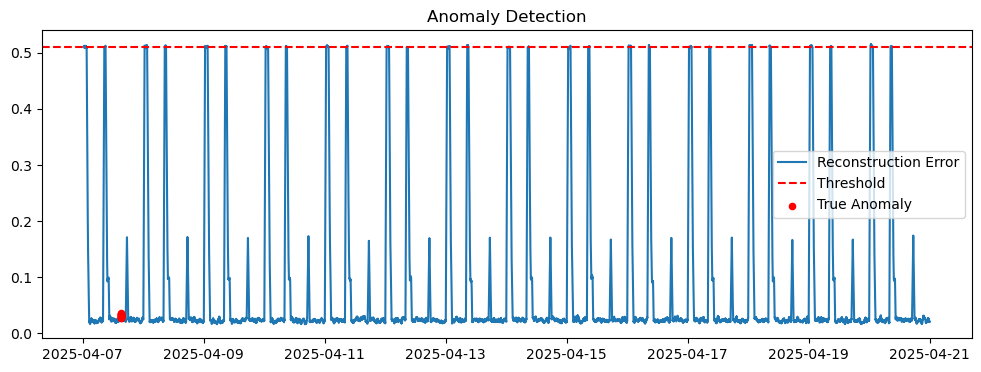

Confusion Matrix:
[[19095  1006]
 [   15     0]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97     20101
     Anomaly       0.00      0.00      0.00        15

    accuracy                           0.95     20116
   macro avg       0.50      0.47      0.49     20116
weighted avg       1.00      0.95      0.97     20116



<Figure size 600x500 with 0 Axes>

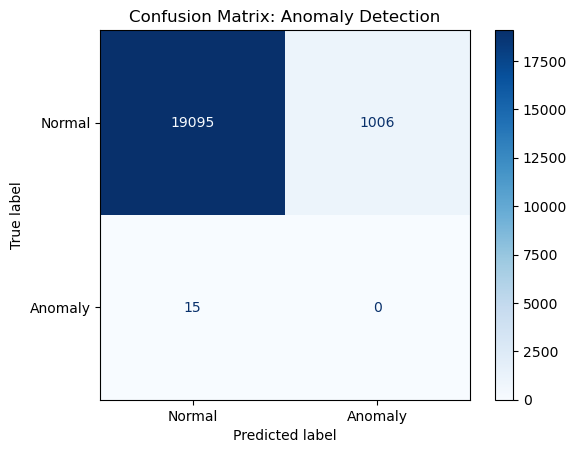

In [ ]:

# Plot anomaly scores
plt.figure(figsize=(12,4))
plt.plot(test_timestamps, losses, label="Reconstruction Error")
plt.axhline(threshold, color='r', linestyle='--', label="Threshold")\

anomaly_mask = y_true == 1  # assuming test_labels is a tensor/array of is_anomaly flags
plt.scatter(
    np.array(test_timestamps)[anomaly_mask],
    np.array(losses)[anomaly_mask],
    color='red',
    label='True Anomaly',
    s=20,
    zorder=5
)

plt.title("Anomaly Detection")
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert boolean to int if needed
y_pred = y_pred.astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])

# Plot
plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Anomaly Detection")
plt.show()

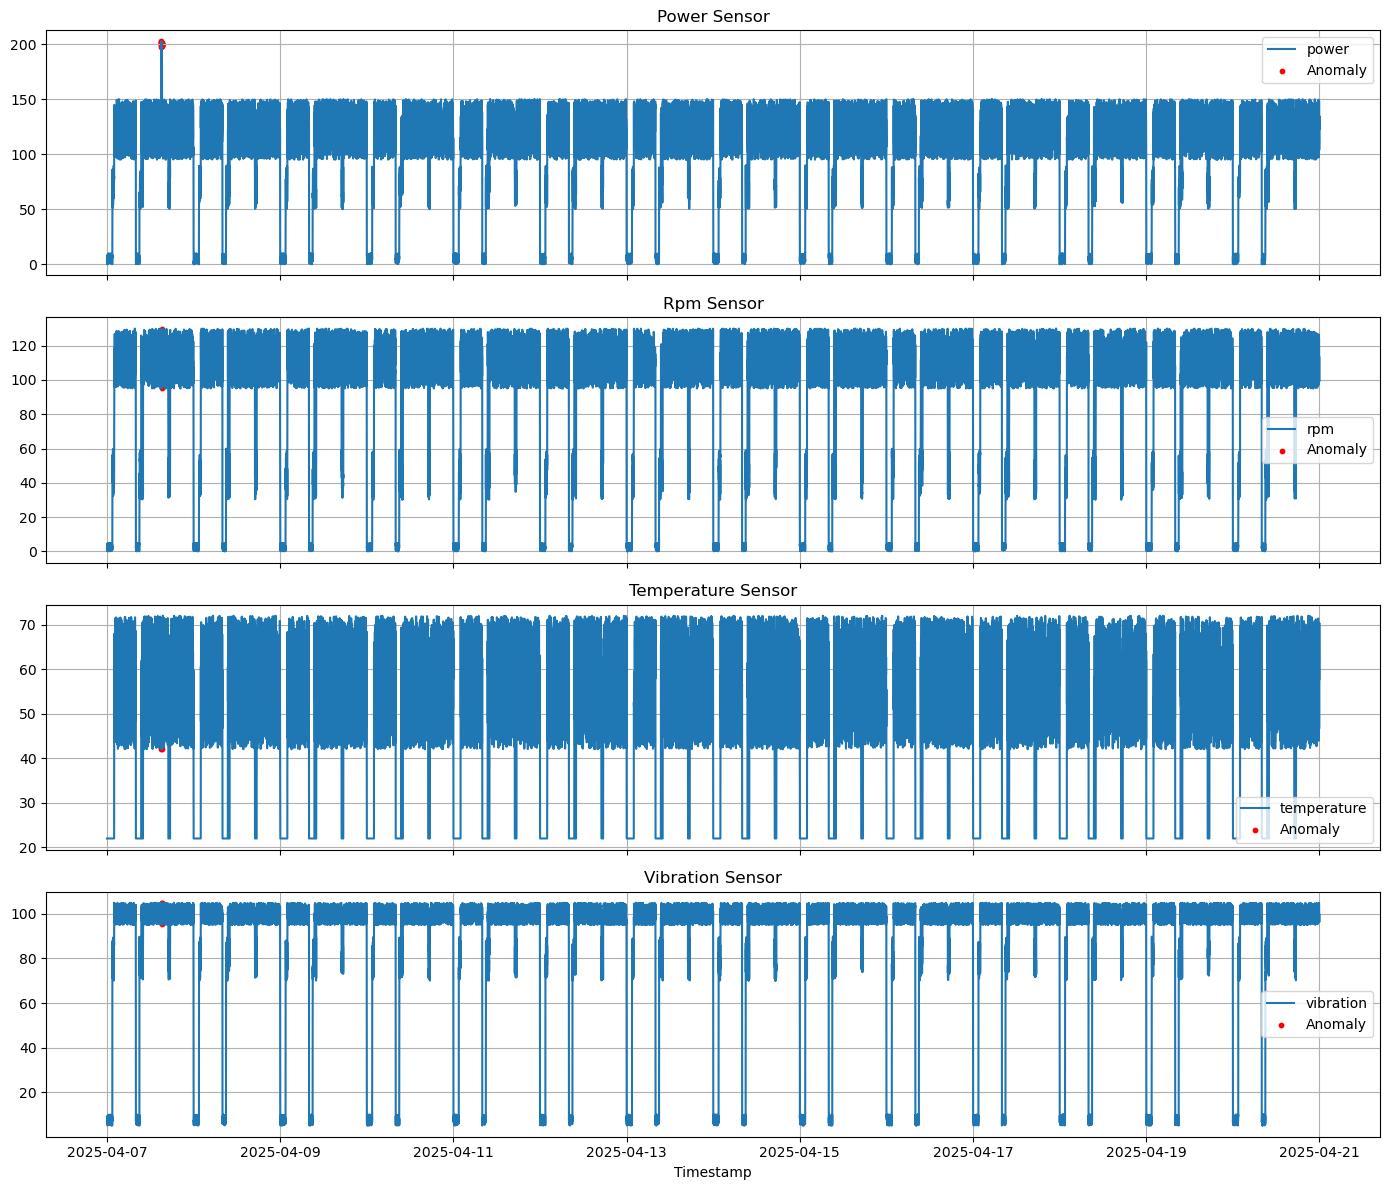

In [ ]:
X, scaler, timestamps, labels, df_pivot, anomaly_map = load_and_prepare_data(
    test_file,
    seq_len=30,
    return_labels=True,
    return_full=True
)

sensor_tags = df_pivot.columns.tolist()

fig, axs = plt.subplots(len(sensor_tags), 1, figsize=(14, 3 * len(sensor_tags)), sharex=True)

for i, tag in enumerate(sensor_tags):
    axs[i].plot(df_pivot.index, df_pivot[tag], label=tag)

    # Highlight anomalies
    anomaly_ts = [ts for ts, val in anomaly_map.items() if val == 1 and ts in df_pivot.index]
    axs[i].scatter(anomaly_ts, df_pivot.loc[anomaly_ts, tag], color='red', s=10, label='Anomaly')

    axs[i].set_title(f"{tag.capitalize()} Sensor")
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()